# Опис програми

## Загальні відомості:

* **Назва проекту**: розподілена система керування.
* **Короткий опис**: цей код реалізує розподілену систему керування з кількома локальними системами керування (ЛСК), що координуються центральним координатором. Координатор обчислює уставки для кожної ЛСК на основі поточної інформації про стан системи, бажаних станів, вхідних даних та стану навколишнього середовища.

## Структура коду

### Класи

* **Coordinator** (Абстрактний): визначає базову структуру та функціональність координатора, включаючи комунікацію через порти, кодування/декодування даних та абстрактний метод для розрахунку уставок.
* **Setpoint** (Конкретний): реалізує алгоритм координації для розрахунку уставок на основі моделі системи, оцінки та прогнозування параметрів, оптимізації уставки та перевірки критерію оптимальності.
* **QueueVisualization**: відповідає за візуалізацію черги даних, використовуючи Tkinter для відображення інформації у таблиці.

### Ключові змінні

* **num_parts**: кількість ЛСК у системі.
* **influence_matrix**: матриця, що описує взаємодію між ЛСК.
* **resource_vector**: вектор, що описує ресурсоємність кожної ЛСК.
* **data_queue**: черга для зберігання даних, отриманих від ЛСК та сенсорів.

### Файли

* **config.json**: файл конфігурації системи, що містить параметри, такі як кількість ЛСК, матриця взаємодії та вектор ресурсоємності.

## Алгоритм координації

Клас **Setpoint** реалізує алгоритм координації, що складається з таких кроків:

1. Отримання даних з черги (поточні стани, бажані стани, вхідні дані, попередні уставки, стан середовища).
2. Моделювання системи на основі поточних станів, вхідних даних та стану середовища.
3. Оцінка параметрів системи на основі моделі та попередніх даних.
4. Прогнозування майбутніх значень параметрів.
5. Оптимізація уставки для кожної ЛСК з урахуванням прогнозованих параметрів та бажаних станів.
6. Перевірка критерію оптимальності для отриманої уставки.

## Комунікація та обмін даними

Координатор має порти для:

* Сенсорів кожної ЛСК.
* Сенсора стану середовища.
* Комунікації з іншими ЛСК.
* Зв'язку з регулятором.

## Формат даних

* Дані кодуються/декодуються у бінарний формат з фіксованою точкою (16 біт, Q8.8).

* Черга даних: використовується черга data_queue для зберігання даних, отриманих від ЛСК та сенсорів.

## Візуалізація стану черги

* Інструменти: Tkinter.

* Відображувані дані: візуалізується вміст черги даних, включаючи поточні стани, бажані стани, вхідні дані, попередні уставки та стан середовища.

* Функціональність: візуалізація періодично оновлюється для відображення змін у файлі, що містить дані черги.


# Програмний код

## Імпортування необхідних бібліотек

In [1]:
import queue
import numpy as np
import json
import struct
from abc import ABC, abstractmethod

In [2]:
from random import randint

In [3]:
import tkinter as tk
from tkinter import ttk
import os

## Основний клас - Координатор

In [4]:
class Coordinator(ABC):
    def __init__(self, config_file, coordinator_index, filename):
        # Збережіть ім'я файлу для зберігання даних
        self.filename = filename
        # Завантаження конфігурації
        with open(config_file) as f:
            config = json.load(f)
        # Зчитуваня розмірності й інші параметри з конфігурації
        self.num_parts = config["num_parts"]
        self.influence_matrix = np.array(config["influence_matrix"])
        self.resource_vector = np.array(config["resource_vector"])
        assert len(self.resource_vector) == self.num_parts, "Розмірності ресурсоємності не співпадають"
        assert self.influence_matrix.shape == (self.num_parts, self.num_parts), "Розмірності матриці взаємодії не співпадають"

        # Індекс координатора
        self.coordinator_index = coordinator_index

        # Ініціалізація черги
        self.data_queue = queue.Queue(maxsize=self.num_parts)

        # Ініціалізація портів (замініть на власну реалізацію)
        self.sensor_port = self._initialize_sensor_port()
        self.environment_port = self._initialize_environment_port()
        self.communication_ports = self._initialize_communication_ports()
        self.regulator_port = self._initialize_regulator_port()

        # Отримання початкових даних
        current_state = self._receive_from_sensor()
        environment_state = self._receive_from_environment_sensor()

        # Створення початкового вектора даних
        initial_data = np.zeros(4 * self.num_parts + 2)
        initial_data[self.coordinator_index] = current_state
        initial_data[-1] = environment_state
        initial_data[-2] = self.num_parts

        # Додавання даних в чергу
        self.data_queue.put(initial_data)

    def _initialize_sensor_port(self) -> int:
        # ... реалізація ініціалізації порту для сенсора
        return randint(1, 3)

    def _initialize_environment_port(self) -> int:
        # ... реалізація ініціалізації порту для сенсора оточуючого середовища
        return randint(1, 3)

    def _initialize_communication_ports(self) -> list[int]:
        # ... реалізація ініціалізації портів для зв'язку з іншими ЛСК
        return [randint(1, 3) for _ in randint(1, 10)]

    def _initialize_regulator_port(self) -> int:
        # ... реалізація ініціалізації порту для зв'язку з регулятором
        return randint(1, 3)

    def _receive_from_sensor(self, port_index=0) -> int:
        # ... реалізація отримання даних від сенсора через порт
        return randint(port_index, 3)

    def _receive_from_environment_sensor(self) -> int:
        # ... реалізація отримання даних від сенсора оточуючого середовища через порт
        return randint(1, 3)

    def receive_data(self, data_source_index):
        # Тимчасова реалізація отримання даних
        decoded_data = self.temp_get_data()
        # # Отримання даних від іншої ЛСК через порт
        # vector = self._receive_from_communication_port(data_source_index)
        # # Декодування та додавання в чергу
        # # ...
        # # Приклад:
        # decoded_data = self._decode_data(vector)
        if self.data_queue.full():
            # Обробка ситуації, коли черга повна (наприклад, видалення найстарішого елемента)
            self.data_queue.get()
        self.data_queue.put(decoded_data)
        # Додати дані до файлу
        with open(self.filename, 'ab') as f:
            np.save(f, decoded_data, allow_pickle=True)

    def temp_get_data(self):
        data = np.zeros(4 * self.num_parts + 2)
        data[self.coordinator_index] = int(input("Enter current state: "))
        data[-1] = int(input("Enter environment state: "))
        data[-2] = self.num_parts
        return data


    def _receive_from_communication_port(self, port_index):
        # ... реалізація отримання даних від іншої ЛСК через порт
        return self._receive_from_sensor(port_index)

    def send_data(self, data):
        # ... кодування та відправка даних іншим ЛСК
        for port in self.communication_ports:
            binary_data = self._encode_data(data)
            self._send_to_communication_port(port, binary_data)

    def _send_to_communication_port(self, port, data):
        # ... реалізація відправки даних іншим ЛСК через порт
        pass

    def send_setpoint(self, setpoint):
        # ... кодування уставки (як раніше)
        vector = self._decode_data(setpoint)
        self._send_to_regulator_port(vector)

    def _send_to_regulator_port(self, data):
        # ... реалізація відправки уставки на регулятор через порт
        pass

    def _encode_data(self, data):
        # Конвертація в бінарний формат з фіксованою точкою (16 біт, Q8.8)
        binary_data = b''.join(struct.pack('<h', int(x * 256)) for x in data)
        return binary_data

    def _decode_data(self, binary_data):
        # Конвертація з бінарного формату з фіксованою точкою (16 біт, Q8.8)
        data = np.array(struct.unpack('<' + 'h'*len(binary_data)//2, binary_data)) / 256
        return data

    def coordination_function(self):
        # Отримання даних з черги
        data = self.data_queue.get()
        # Обчислення уставки
        # ...
        # Приклад:
        setpoint = self.calculate_setpoint_for_LSC(data)
        # Кодування уставки в бінарний формат
        # ...
        binary_output = self._encode_data(setpoint)
        # Append setpoint to the file
        with open(self.filename, 'ab') as f:
            np.save(f, binary_output, allow_pickle=True)
        return binary_output

    @abstractmethod
    def calculate_setpoint_for_LSC(self):
        pass

## Реалізація класу Setpoint на базі Coordinator

In [5]:
class Setpoint(Coordinator):
    def calculate_setpoint_for_LSC(self):
        # Отримання даних з черги
        data = self.data_queue.get()
        current_states = data[:self.num_parts]
        desired_states = data[self.num_parts : 2*self.num_parts]
        input_x = data[2*self.num_parts : 3*self.num_parts]
        previous_setpoints = data[3*self.num_parts : 4*self.num_parts]
        environment_state = data[-1]

        # Приклади методів координації (з використанням розпакованих даних)

        # 1. Модель системи
        system_model = self._system_model(current_states, input_x, environment_state)

        # 2. Оцінювання параметрів
        estimated_parameters = self._estimate_parameters(system_model, current_states, previous_setpoints)

        # 3. Прогнозування параметрів
        predicted_parameters = self._predict_parameters(estimated_parameters)

        # 4. Оптимізація уставки
        optimized_setpoint = self._optimize_setpoint(system_model, predicted_parameters, desired_states)

        # 5. Критерій оптимальності (перевірка)
        if not self._check_optimality_criteria(optimized_setpoint, system_model, desired_states):
            # ... обробка ситуації, коли критерій оптимальності не виконаний
            pass

        return optimized_setpoint

    def _system_model(self, current_states, input_x, environment_state):
        # ... реалізація моделі системи
        return randint(1, 3)

    def _estimate_parameters(self, system_model, current_states, previous_setpoints):
        # ... реалізація оцінювання параметрів
        return randint(1, 3)

    def _predict_parameters(self, estimated_parameters):
        # ... реалізація прогнозування параметрів
        return randint(1, 3)

    def _optimize_setpoint(self, system_model, predicted_parameters, desired_states):
        # ... реалізація оптимізації уставки
        return randint(1, 3)

    def _check_optimality_criteria(self, setpoint, system_model, desired_states):
        # ... реалізація перевірки критерію оптимальності
        return randint(1, 3)

## Програмування візуалізації стану черги

In [6]:
class QueueVisualization:
    def __init__(self, master, filename):
        self.master = master
        self.filename = filename

        # Створюємо таблицю для відображення даних
        self.tree = ttk.Treeview(master, columns=("current_states", "desired_states", "input_x", "previous_setpoints", "environment_state",), show="headings")
        self.tree.heading("current_states", text="current_states")
        self.tree.heading("desired_states", text="desired_states")
        self.tree.heading("input_x", text="input_x")
        self.tree.heading("previous_setpoints", text="previous_setpoints")
        self.tree.heading("environment_state", text="environment_state")
        self.tree.pack()

        # Отримуємо час останньої модифікації файлу, завантажуємо і відображаємо чергу
        self.last_modified_time = os.path.getmtime(filename)
        self.load_queue_and_display()

        # Перевіряємо зміни у файлі кожну секунду
        self.check_file_changes()

    def load_queue_and_display(self):
        # Завантажуємо чергу з файлу та відображаємо її в таблиці
        with open(self.filename, 'rb') as f:
            data_list = np.load(f, allow_pickle=True)

            # Очищаємо поточний вміст таблиці
            for item in self.tree.get_children():
                self.tree.delete(item)

            # Проходимося по кожному елементу черги та відображаємо їх
            for idx, data in enumerate(data_list):
                num_parts = int(data[-2])
                current_states = data[:num_parts]
                desired_states = data[num_parts : 2*num_parts]
                input_x = data[2*num_parts : 3*num_parts]
                previous_setpoints = data[3*num_parts : 4*num_parts]
                environment_state = data[-1]

                self.tree.insert("", "end", text=str(idx+1), values=(current_states, desired_states, input_x, previous_setpoints, environment_state))

    def check_file_changes(self):
        # Перевіряємо зміни у файлі. Якщо файл змінився, оновлюємо відображення даних
        current_modified_time = os.path.getmtime(self.filename)
        if current_modified_time != self.last_modified_time:
            self.last_modified_time = current_modified_time
            self.load_queue_and_display()

        # Перевіряємо зміни у файлі кожну секунду
        self.master.after(1000, self.check_file_changes)


## Приклад відображення

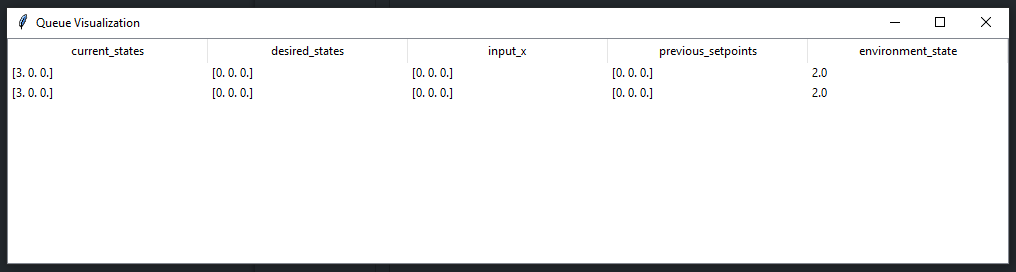

# Приклад використання

У коді методу receive_data було симульовано отримання даних(також отримання значень поточного та стану середовища) та додача їх у бінарному вигляді до файлу. Метод, що відповідає за відображення даних виводив їх у консоль.

На рисунку нижче ліва консоль відповідає за введення значень станів, а консоль справа виводить стан черги. В один момент часу запущено два скрипти.

```python
s = Setpoint("config.json", 0, "test_data.npy")
while True:
    from time import sleep

    s.receive_data(0)
    sleep(3)

q = QueueVisualization("config.json", "test_data.npy")
```

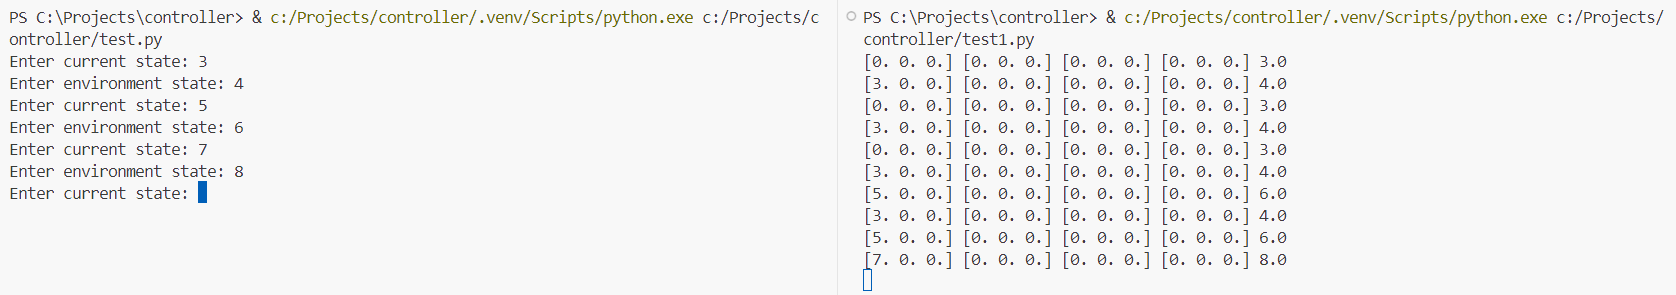